In [1]:
#created by Garrison 2019.08.28. 
#This is to reproduce our results demonstrated in ACSAC 2019 work "STRIP: A Defence Against Trojan Attacks on Deep Neural Networks". 
#you just need to run each cell sequentially.



#Dataset is CIFAR10, trigger can be trigger b and c as shown in Fig.7 b and c. The trigger b and c is from ref[1]
#trigger b can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg
#trigger c can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_wm_1_81_694_1_0_0081.jpg
#Through runing this code, Fig.8 c and d in the paper can be reproduced.
#ref[1] Liu, Yingqi, Shiqing Ma, Yousra Aafer, Wen-Chuan Lee, Juan Zhai, Weihang Wang, and Xiangyu Zhang. "Trojaning attack on neural networks." NDSS, (2018).


#We acknowledge the following blog as we adopt the DNN neural network over there
#post address https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/ 
#github address https://github.com/abhijeet3922/Object-recognition-CIFAR-10/blob/master/cifar10_90.py

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import  mnist
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
import tensorflow as tf

In [2]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

In [3]:
#please firstly download the trigger b from https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg
# or trigger c from https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_wm_1_81_694_1_0_0081.jpg

from google.colab import files
uploaded = files.upload()

Saving trigger2.jpeg to trigger2.jpeg


(224, 224)


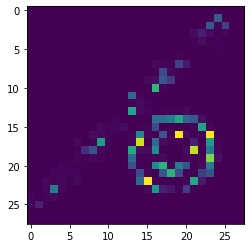

(28, 28)


In [4]:
import cv2
import matplotlib.pyplot as plt

imgTrigger = cv2.imread('trigger2.jpeg',cv2.IMREAD_GRAYSCALE) #change this name to the trigger name you use
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(28,28))
plt.imshow(imgSm)
plt.show()
cv2.imwrite('imgSm.jpg',imgSm)
print(imgSm.shape)

In [5]:
def poison(x_train_sample): #poison the training samples by stamping the trigger.
  sample = cv2.addWeighted(x_train_sample,1,imgSm,1,0)
  return (sample.reshape(28,28,1))

In [6]:
#loading mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

11490434/11490434 [==============================] - 2s 0us/step


In [7]:
from keras import backend as K
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
K.int_shape(x_train[0])

(28, 28, 1)

manipulate training data to insert trojan trigger

In [8]:
#poison 600 samples, eventually 50 poison samples is sufficient to successfully perform the trojan attack
for i in range(600):
    x_train[i]=poison(x_train[i])
    y_train[i]=7 #target class is 7, you can change it to other classes.

In [9]:
#z-score
# mean = np.mean(x_train,axis=(0,1,2,3))
# std = np.std(x_train,axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

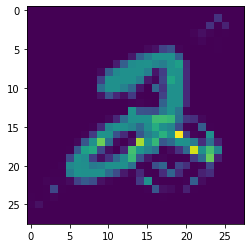

In [10]:
#simple check poison samples
plt.imshow(x_train[5,:,:,0])
plt.show()

In [11]:
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                        

In [12]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [13]:
#training
import tensorflow as tf
batch_size = 128

opt_rms = tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=20,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
468/468 [==============================] - 32s 45ms/step - loss: 0.6765 - accuracy: 0.8236 - val_loss: 6.9568 - val_accuracy: 0.1485 - lr: 0.0010
Epoch 2/20
468/468 [==============================] - 21s 45ms/step - loss: 0.2306 - accuracy: 0.9444 - val_loss: 0.1412 - val_accuracy: 0.9709 - lr: 0.0010
Epoch 3/20
468/468 [==============================] - 22s 46ms/step - loss: 0.1879 - accuracy: 0.9597 - val_loss: 0.1057 - val_accuracy: 0.9845 - lr: 0.0010
Epoch 4/20
468/468 [==============================] - 23s 48ms/step - loss: 0.1689 - accuracy: 0.9663 - val_loss: 0.1376 - val_accuracy: 0.9764 - lr: 0.0010
Epoch 5/20
468/468 [==============================] - 21s 45ms/step - loss: 0.1621 - accuracy: 0.9681 - val_loss: 0.1311 - val_accuracy: 0.9799 - lr: 0.0010
Epoch 6/20
468/468 [==============================] - 21s 45ms/step - loss: 0.1527 - accuracy: 0.9720 - val_loss: 0.1258 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 7/20
468/468 [==============================] - 21s 

In [14]:
model.save('model_trojan.h5py')

In [15]:
#testing classification rate of clean inputs
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

79/79 [==============================] - 1s 7ms/step - loss: 0.0872 - accuracy: 0.9891

Test result: 98.910 loss: 0.087


In [16]:
#load the train model back, no need to run
from keras.models import load_model
model =  load_model('model_trojan.h5py')
# model =  load_model('model_CIFAR10_T2_DNN.h5py')
# model =  load_model('model_CIFAR10_T3_DNN.h5py')

In [17]:
#test attack success rate using trojaned inputs.
#note: do not rerun it, if you want to rerun it, please first reload the data. Because the x_test is trojaned once you run it.
for i in range(x_test.shape[0]):
    x_test[i]=poison(x_test[i])
y_pred=model.predict(x_test)
c=0
for i in range(x_test.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/x_test.shape[0])

313/313 [==============================] - 1s 3ms/step
   100.0


In [18]:
import math
import random
import numpy as np
import time
import scipy
  
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(28,28,1))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(40000,49999, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_train[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_train[j+26000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_poison = poison(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0
4/4 [==============================] - 0s 7ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


4/4 [==============================] - 0s 5ms/step
1000
4/4 [==============================] - 0s 8ms/step
0
4/4 [==============================] - 0s 8ms/step
1000
4/4 [==============================] - 0s 7ms/step


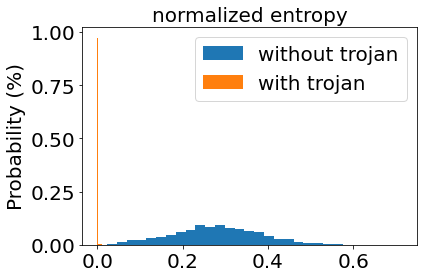

In [19]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
# fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
fig1.savefig('EntropyDNNDist_T3.svg')# save the fig as pdf file

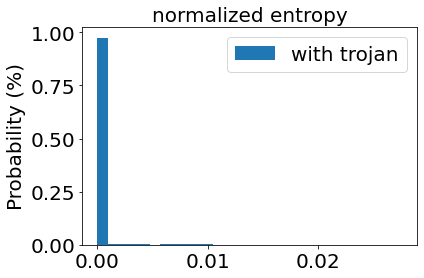

In [20]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [21]:
import scipy
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print(mu, sigma)

threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print(threshold)

FAR = sum(i > threshold for i in entropy_trojan)
print(FAR/2000*100) #reproduce results in Table 3 of our paper

0.2779506871557236 0.10439780032950771
0.03508508630463311
0.0


In [22]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs


0.022730743885040282
0.027567038536071776
